In [11]:
# Wrangling data
import numpy as np
import pandas as pd
import warnings

# Visualizing the data 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Some aggregation to statisticize data 
from scipy.stats.mstats import trimmed_var

# Build model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


In [12]:
warnings.filterwarnings(action='ignore')
pd.options.display.float_format = '{:.3f}'.format

# Prepare Data

## Import

We spent some time in the last lesson zooming in on a useful subset of the SCF, and this time, we're going to zoom in even further. One of the persistent issues we've had with this dataset is that it includes some outliers in the form of ultra-wealthy households. This didn't make much of a difference for our last analysis, but it could pose a problem in this lesson, so we're going to focus on families with net worth under \\$2 million.

In [2]:
def wrangle(filepath):
    df= pd.read_csv(filepath)
    mask = (df['TURNFEAR'] ==1) & (df['NETWORTH']<2_000_000)
    df=df[mask]
    return df

In [4]:
df = wrangle('data/SCFP2019.csv')
print(df.shape)
df.head()

(4418, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
5,2,21,3790.476607,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
6,2,22,3798.868505,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,3,2,2
7,2,23,3799.468393,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
8,2,24,3788.076005,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
9,2,25,3793.066589,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2


## Explore

In this lesson, we want to make clusters using more than two features, but which of the 351 features should we choose? Often times, this decision will be made for you. For example, a stakeholder could give you a list of the features that are most important to them. If you don't have that limitation, though, another way to choose the best features for clustering is to determine which numerical features have the largest **variance**. That's what we'll do here. 

In [13]:
# Calculate variance, get 10 largest features
top_ten_var = df.var().sort_values().tail(10)
top_ten_var

PLOAN1     11408942527.828
ACTBUS     12518916948.613
BUS        12566432445.276
KGTOTAL    13464753169.729
DEBT       18482520920.408
NHNFIN     22541633958.338
HOUSES     23884594633.764
NETWORTH   48470286637.424
NFIN       57139390964.956
ASSET      83039666928.199
dtype: float64

- Visualize the top ten of features which have the most variance

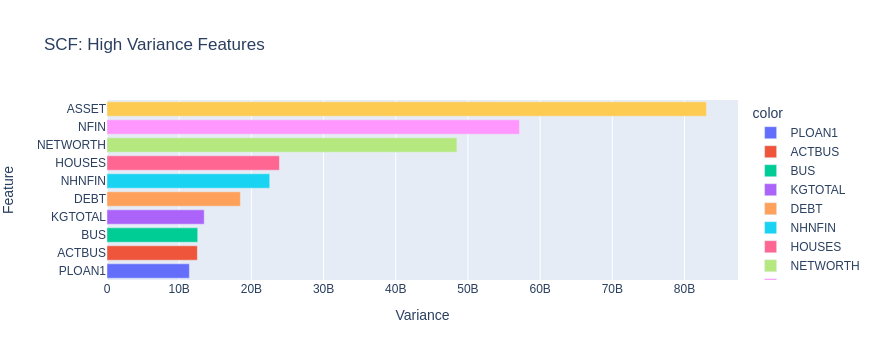

In [8]:
# Create horizontal bar chart of `top_ten_var`
fig = px.bar(
    x=top_ten_var,
    y=top_ten_var.index,
    color=top_ten_var.index,
    title="SCF: High Variance Features"
)
fig.update_layout(xaxis_title="Variance", yaxis_title="Feature")
fig.show()

One thing that we've seen throughout this project is that many of the wealth indicators are highly skewed, with a few outlier households having enormous wealth. Those outliers can affect our measure of variance. Let's see if that's the case with one of the features from `top_five_var`.

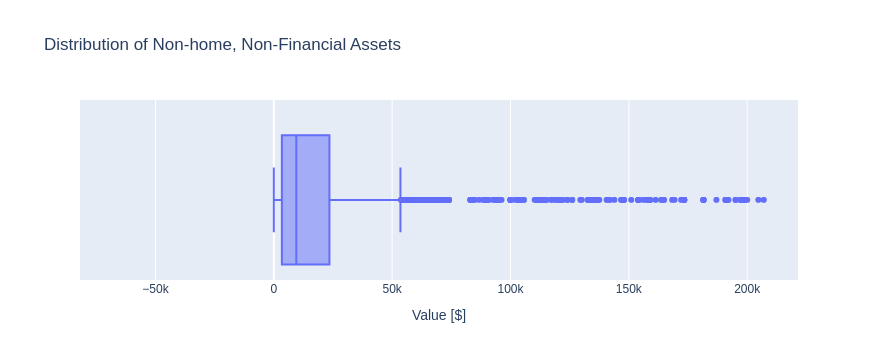

In [9]:
# Create a boxplot of `NHNFIN`
fig = px.box(
    data_frame=df,
    x='NHNFIN',
    title="Distribution of Non-home, Non-Financial Assets"
)
fig.update_layout(xaxis_title="Value [$]")
fig.show()

Whoa! The dataset is massively right-skewed because of the huge outliers on the right side of the distribution. Even though we already excluded households with a high net worth with our `wrangle` function, the variance is still being distorted by some extreme outliers.

The best way to deal with this is to look at the **trimmed variance**, where we remove extreme values before calculating variance. We can do this using the `trimmed_variance` function from the `SciPy` library.

In [14]:
# Calculate trimmed variance
top_ten_trim_var = df.apply(trimmed_var, limits=(0.1,0.1)).sort_values().tail(10)
top_ten_trim_var

WAGEINC      555073745.596
HOMEEQ       733837686.025
NH_MORT     1333125491.901
MRTHEL      1380467574.437
PLOAN1      1441968346.380
DEBT        3089864647.656
NETWORTH    3099929075.229
HOUSES      4978660011.139
NFIN        8456441584.954
ASSET      11753695011.531
dtype: float64

- Visualizing the top ten feature with trimmed var

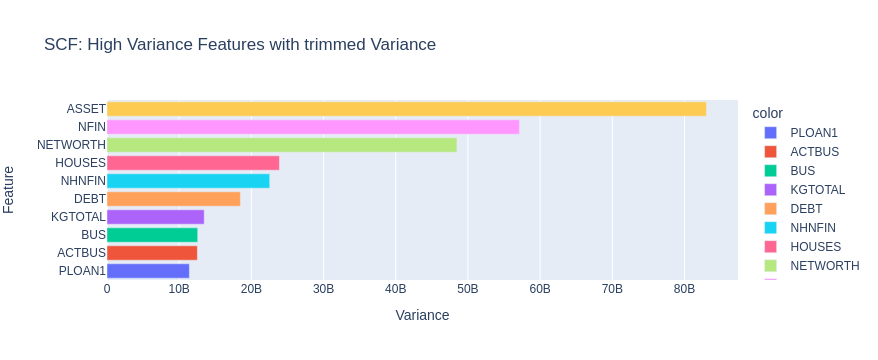

In [18]:
fig = px.bar(
    x=top_ten_var,
    y=top_ten_var.index,
    color = top_ten_var.index,
    title="SCF: High Variance Features with trimmed Variance"
)
fig.update_layout(xaxis_title="Variance", yaxis_title="Feature")
fig.show()

There are three things to notice in this plot. First, the variances have decreased a lot. In our previous chart, the x-axis went up to \\$80 billion; this one goes up to \\$12 billion. Second, the top 10 features have changed a bit. All the features relating to business ownership (`"...BUS"`) are gone. Finally, we can see that there are big differences in variance from feature to feature. For example, the variance for `"WAGEINC"` is around than \\$500 million, while the variance for `"ASSET"` is nearly \\$12 billion. In other words, these features have completely different scales. This is something that we'll need to address before we can make good clusters. 

## Split 

In [20]:
high_var_cols = top_ten_trim_var.tail(5).index.to_list()
high_var_cols

['DEBT', 'NETWORTH', 'HOUSES', 'NFIN', 'ASSET']

In [21]:
X = df[high_var_cols]
print("X shape:", X.shape)
X.head()

X shape: (4418, 5)


,DEBT,NETWORTH,HOUSES,NFIN,ASSET
5,12200.000,-6710.000,0.000,3900.000,5490.000
6,12600.000,-4710.000,0.000,6300.000,7890.000
7,15300.000,-8115.000,0.000,5600.000,7185.000
8,14100.000,-2510.000,0.000,10000.000,11590.000
9,15400.000,-5715.000,0.000,8100.000,9685.000


**Notes:** 

Due to this is the unsupervised learning, there no `Label/Target` for predition aim

# Build Model 

## Iteration 

During our EDA, we saw that we had a scale issue among our features. That issue can make it harder to cluster the data, so we'll need to fix that to help our analysis along. One strategy we can use is **standardization**, a statistical method for putting all the variables in a dataset on the same scale. Let's explore how that works here. Later, we'll incorporate it into our model pipeline. 

In [23]:
# Calculate the mean and std for all features
X_summary = X.agg(['mean','std']).astype(int)
X_summary

,DEBT,NETWORTH,HOUSES,NFIN,ASSET
mean,72701,76387,74530,117330,149089
std,135950,220159,154546,239038,288166


In [24]:
# Instantiate transformer
scaler = StandardScaler()

# Transform `X`
X_scaled_data = scaler.fit_transform(X)

# Put `X_scaled_data` into DataFrame
X_scaled = pd.DataFrame(data=X_scaled_data,columns=X.columns)

print("X_scaled shape:", X_scaled.shape)
X_scaled.head()

X_scaled shape: (4418, 5)


,DEBT,NETWORTH,HOUSES,NFIN,ASSET
0,-0.445,-0.377,-0.482,-0.475,-0.498
1,-0.442,-0.368,-0.482,-0.465,-0.490
2,-0.422,-0.384,-0.482,-0.467,-0.492
3,-0.431,-0.358,-0.482,-0.449,-0.477
4,-0.422,-0.373,-0.482,-0.457,-0.484


In [25]:
n_clusters = range(2,13)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    # buid model 
    model = make_pipeline(
                StandardScaler(),
                KMeans(n_clusters=k, random_state=42)
    )
    
    model.fit(X)
    
    # Calculate inertia
    inertia_errors.append(model.named_steps['kmeans'].inertia_)
    
    # Calculate silhouette_scores
    silhouette_scores.append(
            silhouette_score(X,model.named_steps['kmeans'].labels_)
    )

print("Inertia:", inertia_errors[:3])
print()
print("Silhouette Scores:", silhouette_scores[:3])

Inertia: [11028.058082607182, 7190.526303575347, 5924.997726868024]

Silhouette Scores: [0.7464502937083215, 0.7044601307791996, 0.6962653079183132]


Just like last time, let's create an elbow plot to see how many clusters we should use. 

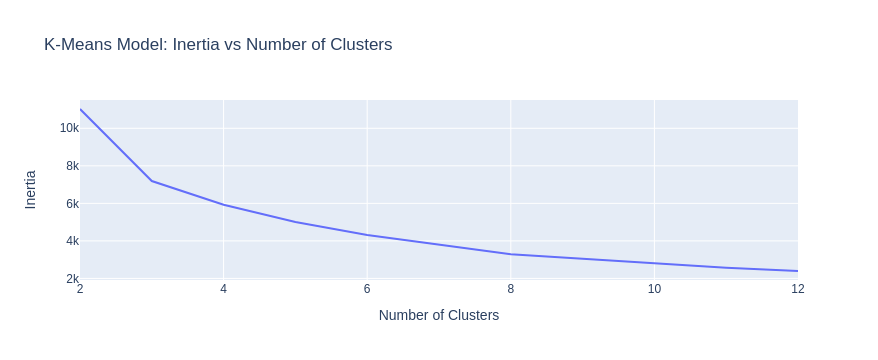

In [26]:
# Create line plot of `inertia_errors` vs `n_clusters`
fig = px.line(
    x=n_clusters, y=inertia_errors,title='K-Means Model: Inertia vs Number of Clusters'
)
fig.update_layout(xaxis_title="Number of Clusters", yaxis_title="Inertia")
fig.show()

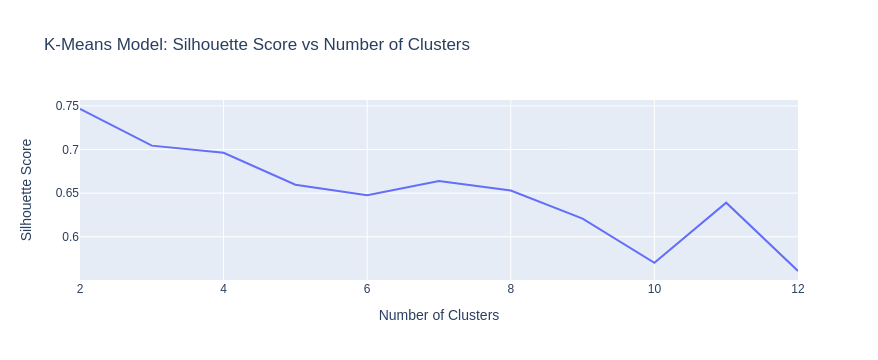

In [27]:
# Create a line plot of `silhouette_scores` vs `n_clusters`
fig = px.line(
    x=n_clusters, 
    y=silhouette_scores,
    title="K-Means Model: Silhouette Score vs Number of Clusters"
)
fig.update_layout(xaxis_title="Number of Clusters", yaxis_title="Silhouette Score")

fig.show()

**Note:** 

We could see the model is efficient with `n_cluster = 4`. It gives the best Silhouette Score as well as Inertia score

## Final model

In [28]:
final_model = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=4,random_state=42)
)
final_model.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=4, random_state=42))])

# Communication 

In [29]:
labels = final_model.named_steps['kmeans'].labels_
print(labels[:5])

[0 0 0 0 0]


Create a DataFrame `xgb` that contains the mean values of the features in `X` for each of the clusters in your `final_model`.

In [30]:
xgb = X.groupby(labels).mean()
xgb

,DEBT,NETWORTH,HOUSES,NFIN,ASSET
0,26551.075,13676.153,13745.638,27226.047,40227.229
1,218112.818,174713.442,257403.247,330588.351,392826.260
2,116160.780,965764.156,264339.450,780061.147,1081924.936
3,732937.576,760397.576,826136.364,1276227.273,1493335.152


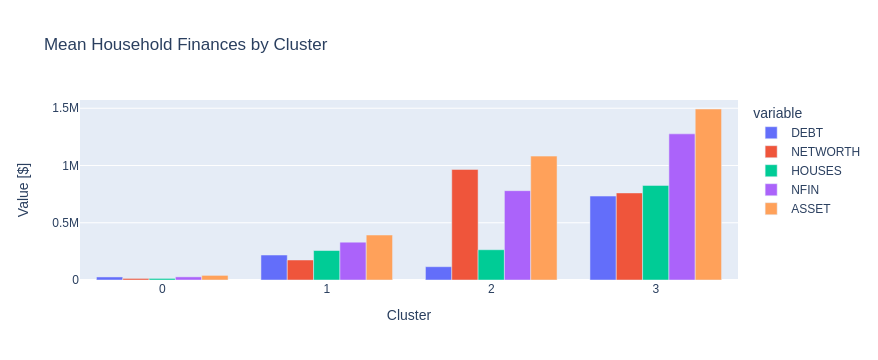

In [31]:
# Create side-by-side bar chart of `xgb`
fig = px.bar(data_frame=xgb,barmode='group',title="Mean Household Finances by Cluster")
fig.update_layout(xaxis_title="Cluster", yaxis_title="Value [$]")
fig.show()

Remember that our clusters are based partially on `NETWORTH`, which means that the households in the 0 cluster have the smallest net worth, and the households in the 2 cluster have the highest. Based on that, there are some interesting things to unpack here.

First, take a look at the `DEBT` variable. You might think that it would scale as net worth increases, but it doesn't. The lowest amount of debt is carried by the households in cluster 2, even though the value of their houses (shown in green) is roughly the same. You can't *really* tell from this data what's going on, but one possibility might be that the people in cluster 2 have enough money to pay down their debts, but not quite enough money to leverage what they have into additional debts. The people in cluster 3, by contrast, might not need to worry about carrying debt because their net worth is so high. 

Finally, since we started out this project looking at home values, take a look at the relationship between `DEBT` and `HOUSES`. The value of the debt for the people in cluster 0 is higher than the value of their houses, suggesting that most of the debt being carried by those people is tied up in their mortgages — if they own a home at all. Contrast that with the other three clusters: the value of everyone else's debt is lower than the value of their homes.

So all that's pretty interesting, but it's different from what we did last time, right? At this point in the last lesson, we  made a scatter plot. This was a straightforward task because we only worked with two features, so we could plot the data points in two dimensions. But now `X` has five dimensions! How can we plot this to give stakeholders a sense of our clusters?

Since we're working with a computer screen, we don't have much of a choice about the number of dimensions we can use: it's got to be two. So, if we're going to do anything like the scatter plot we made before, we'll need to take our 5-dimensional data and change it into something we can look at in 2 dimensions.

In [32]:
# Instantiate transformer
pca = PCA(n_components=2)

# Transform `X`
X_t = pca.fit_transform(X)

# Put `X_t` into DataFrame
X_pca = pd.DataFrame(X_t, columns=['PC1','PC2'])

print("X_pca shape:", X_pca.shape)
X_pca.head()

X_pca shape: (4418, 2)


,PC1,PC2
0,-221525.425,-22052.273
1,-217775.101,-22851.358
2,-219519.642,-19023.646
3,-212195.720,-22957.107
4,-215540.508,-20259.749


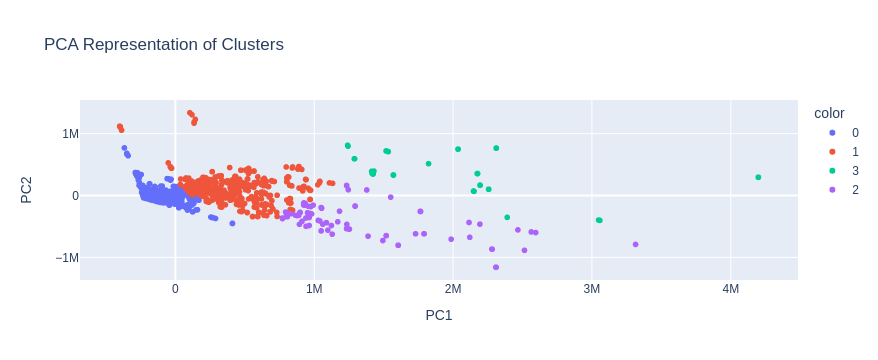

In [33]:
# Create scatter plot of `PC2` vs `PC1`
fig = px.scatter(data_frame=X_pca,
                 x='PC1',
                 y='PC2',
                 color=labels.astype(str),
                 title="PCA Representation of Clusters",
                )

fig.update_layout(xaxis_title='PC1',yaxis_title='PC2')

fig.show()

One limitation of this plot is that it's hard to explain what the axes here represent. In fact, both of them are a combination of the five features we originally had in `X`, which means this is pretty abstract. Still, it's the best way we have to show as much information as possible as an explanatory tool for people outside the data science community. 

So what does this graph mean? It means that we made four tightly-grouped clusters that share some key features. If we were presenting this to a group of stakeholders, it might be useful to show this graph first as a kind of warm-up, since most people understand how a two-dimensional object works. Then we could move on to a more nuanced analysis of the data.

Just something to keep in mind as you continue your data science journey.